In [1]:
import matplotlib.pyplot as plt
import sys  
sys.path.insert(0, '/Users/szczekulskij/side_projects/long-term-analysis-of-pws')
from src.generate_df import get_data_df
from src.graphs import graph_agg_metric_over_nr_sessions, graph_based_on_time_bucket, plot_fig6A_graph
from src.anovas import bucketed_anova
from src.statistics import get_medians

In [2]:
df = get_data_df(metric = "total_GCE")
print("nr of patients: ", len(df.surname.unique()))
print("nr of sessions: ", len(df))
print(f"from {df.visit_nr.min()} to {df.visit_nr.max()} sessions ")

nr of patients:  55
nr of sessions:  412
from 1 to 37 sessions 


# Main graphs & stats:

In [3]:
get_medians(metric = "total_GCE", buckets_visit_nr = [2,5,10,15,20,1000], agg_type="median")

metrics:  total_GCE
for first 2 visits, the median maximal total_GCE was 31.19
for first 5 visits, the median maximal total_GCE was 49.84
for first 10 visits, the median maximal total_GCE was 58.01
for first 15 visits, the median maximal total_GCE was 60.13
for first 20 visits, the median maximal total_GCE was 60.17
for first 1000 visits, the median maximal total_GCE was 63.61


/usr/local/lib/python3.10/site-packages/pandas/core/apply.py:507: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  return self._try_aggregate_string_function(obj, f, *self.args, **self.kwargs)


Text(0.5, 0, 'number of laser sessions')

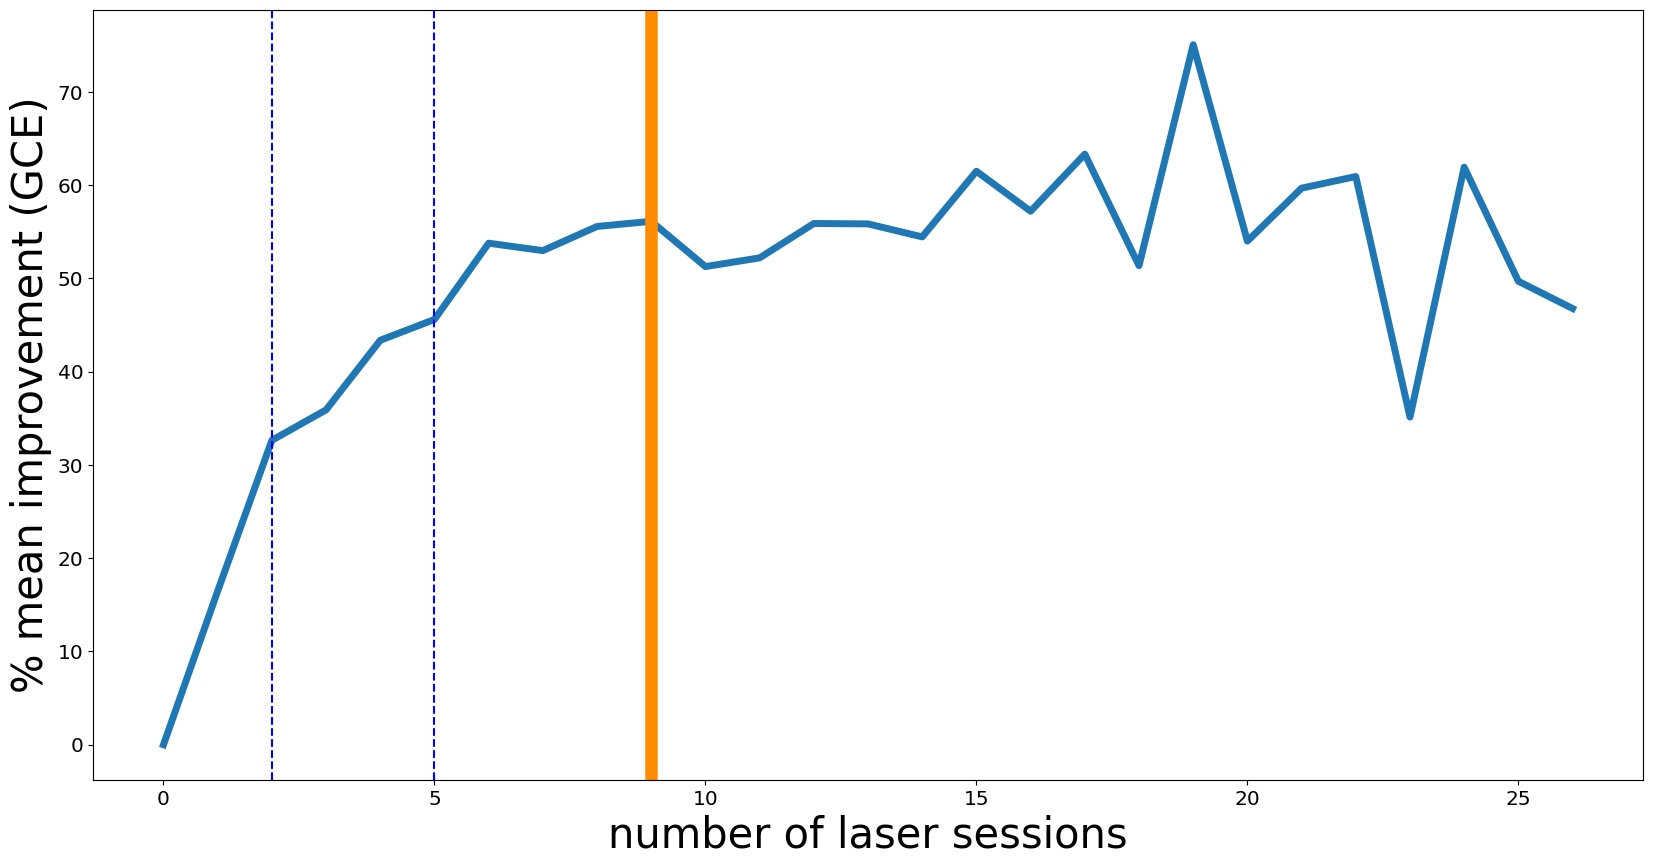

In [4]:
plt.figure(figsize=(20,10))
graph_agg_metric_over_nr_sessions("total_GCE", cut_last_x_visits = 27)
plt.axvline(x=2, color='b', linestyle='--')
plt.axvline(x=5, color='b', linestyle='--')
plt.axvline(x=9, color='darkorange', linestyle='-',  lw = 9)
plt.ylabel("% mean improvement (GCE)", size = 30)
plt.xlabel("number of laser sessions", size = 30)





anova results:
buckets: [1, 3, 6, 10, 15]
p_value: 2.672068635067671e-16

statistics between 1 - 2 bucket and 3 - 5 bucket
means: 24.95486 vs 41.40823
p-value: 0.0

statistics between 3 - 5 bucket and 6 - 9 bucket
means: 41.40823 vs 54.43362
p-value: 6e-05

statistics between 6 - 9 bucket and 10 - 14 bucket
means: 54.43362 vs 53.55368
p-value: 0.59677



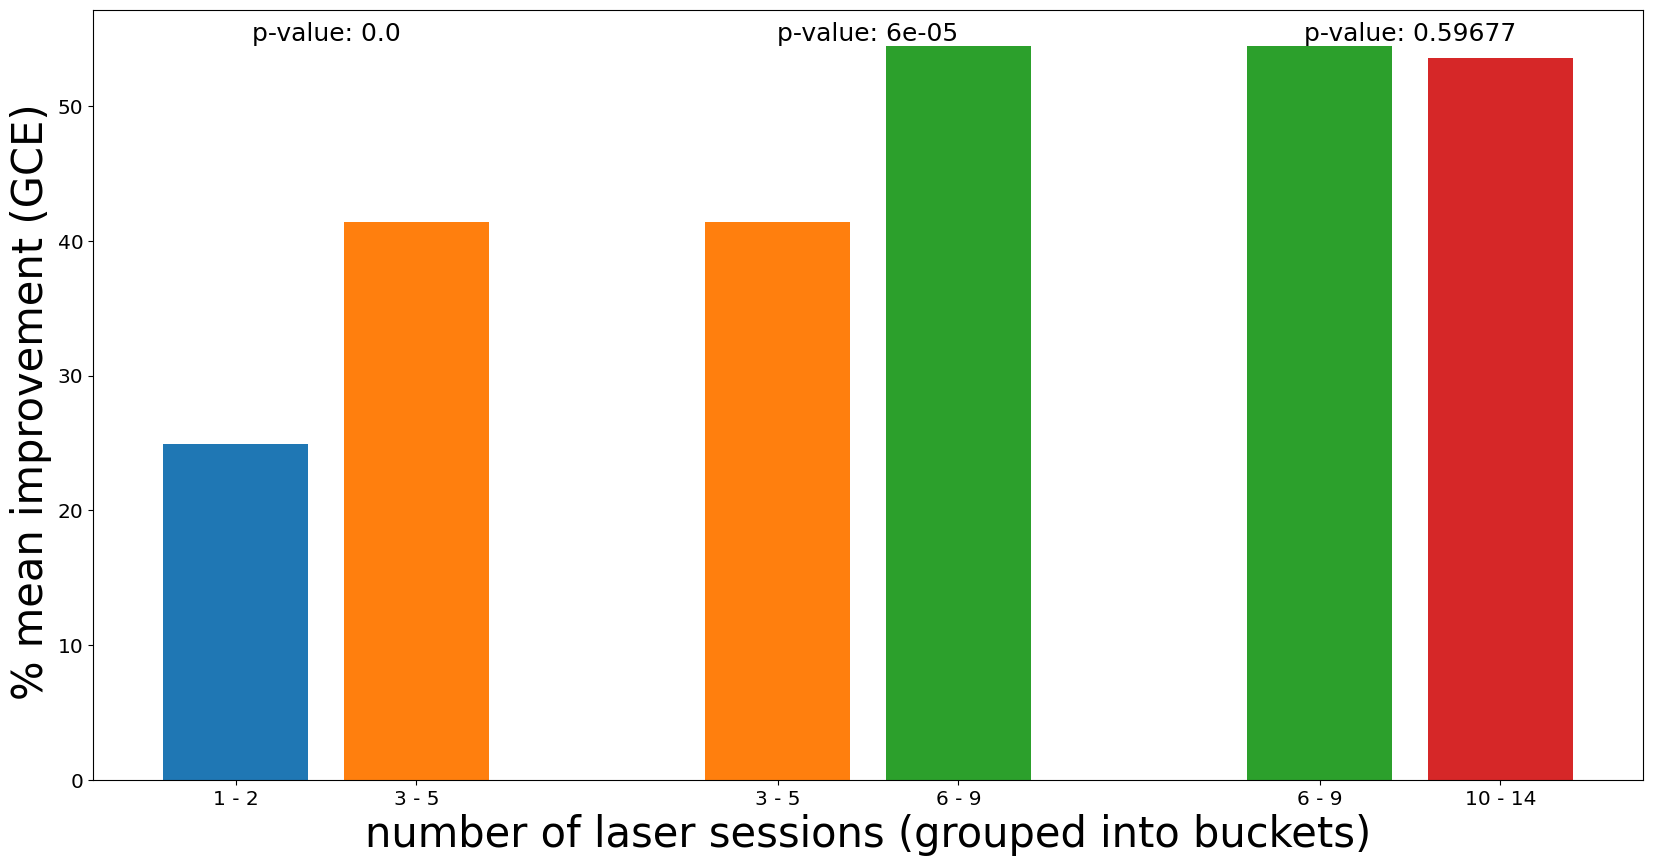

In [5]:
plt.figure(figsize=(20,10))
plt.ylabel("% mean improvement (GCE) ", size = 30)
plt.xlabel("number of laser sessions (grouped into buckets)", size = 30)
bucketed_anova(
    bucket_column = "visit_nr",
    metric = "total_GCE",
    buckets = [1,3,6,10,15,],
    ttest_type = "less",
    p_value_text_height = 54.50
)

buckets:  [0, 90, 180, 270]
['0 - 90', '90 - 180', '180 - 270', '270+']


,bucket,visits_per_bucket
0,0 - 90,255
1,90 - 180,41
2,180 - 270,21
3,270+,15


Text(0, 0.5, '% mean improvement (GCE)\ninbetween two consecutive visits')

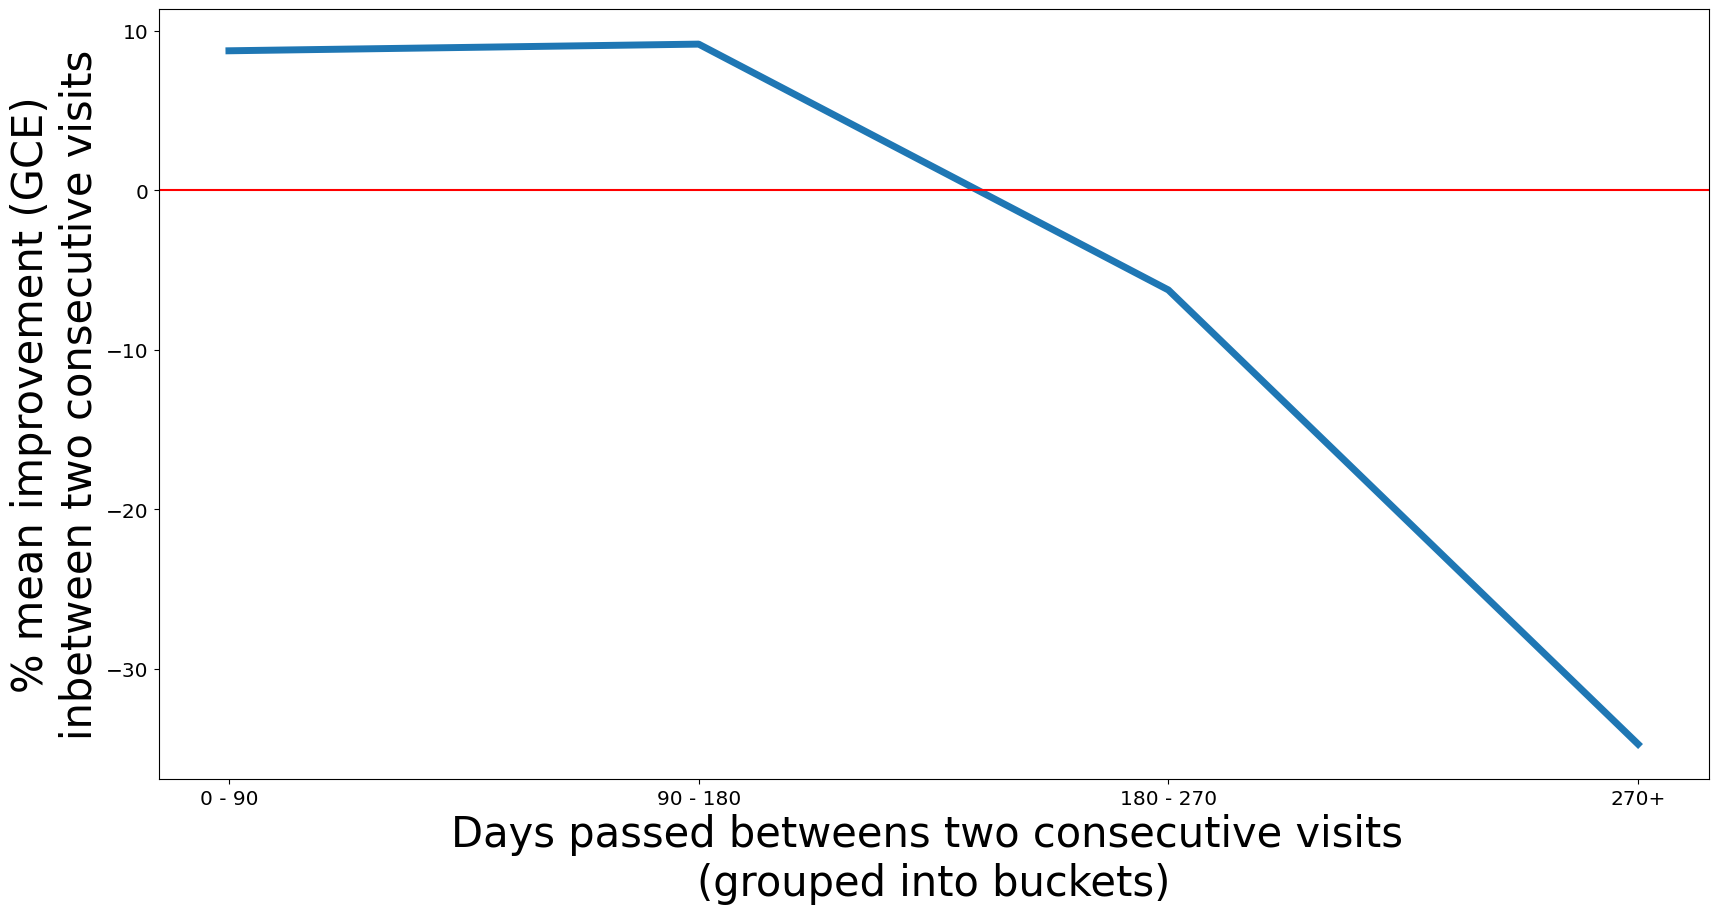

In [6]:
plt.figure(figsize=(20,10))
graph_based_on_time_bucket("inbetween_GCE", buckets_nr = 4, increment = 90)
plt.xlabel("Days passed betweens two consecutive visits \n(grouped into buckets)", size = 30)
plt.ylabel("% mean improvement (GCE)\ninbetween two consecutive visits", size = 30)





anova results:
buckets: [0, 90, 180, 270, 10000]
p_value: 1.99238094142645e-08

statistics between 0 - 89 bucket and 90 - 179 bucket
means: 8.73807 vs 9.15541
p-value: 0.54361

statistics between 90 - 179 bucket and 180 - 269 bucket
means: 9.15541 vs -6.2455
p-value: 0.01299

statistics between 180 - 269 bucket and 270+ bucket
means: -6.2455 vs -34.69934
p-value: 0.0573



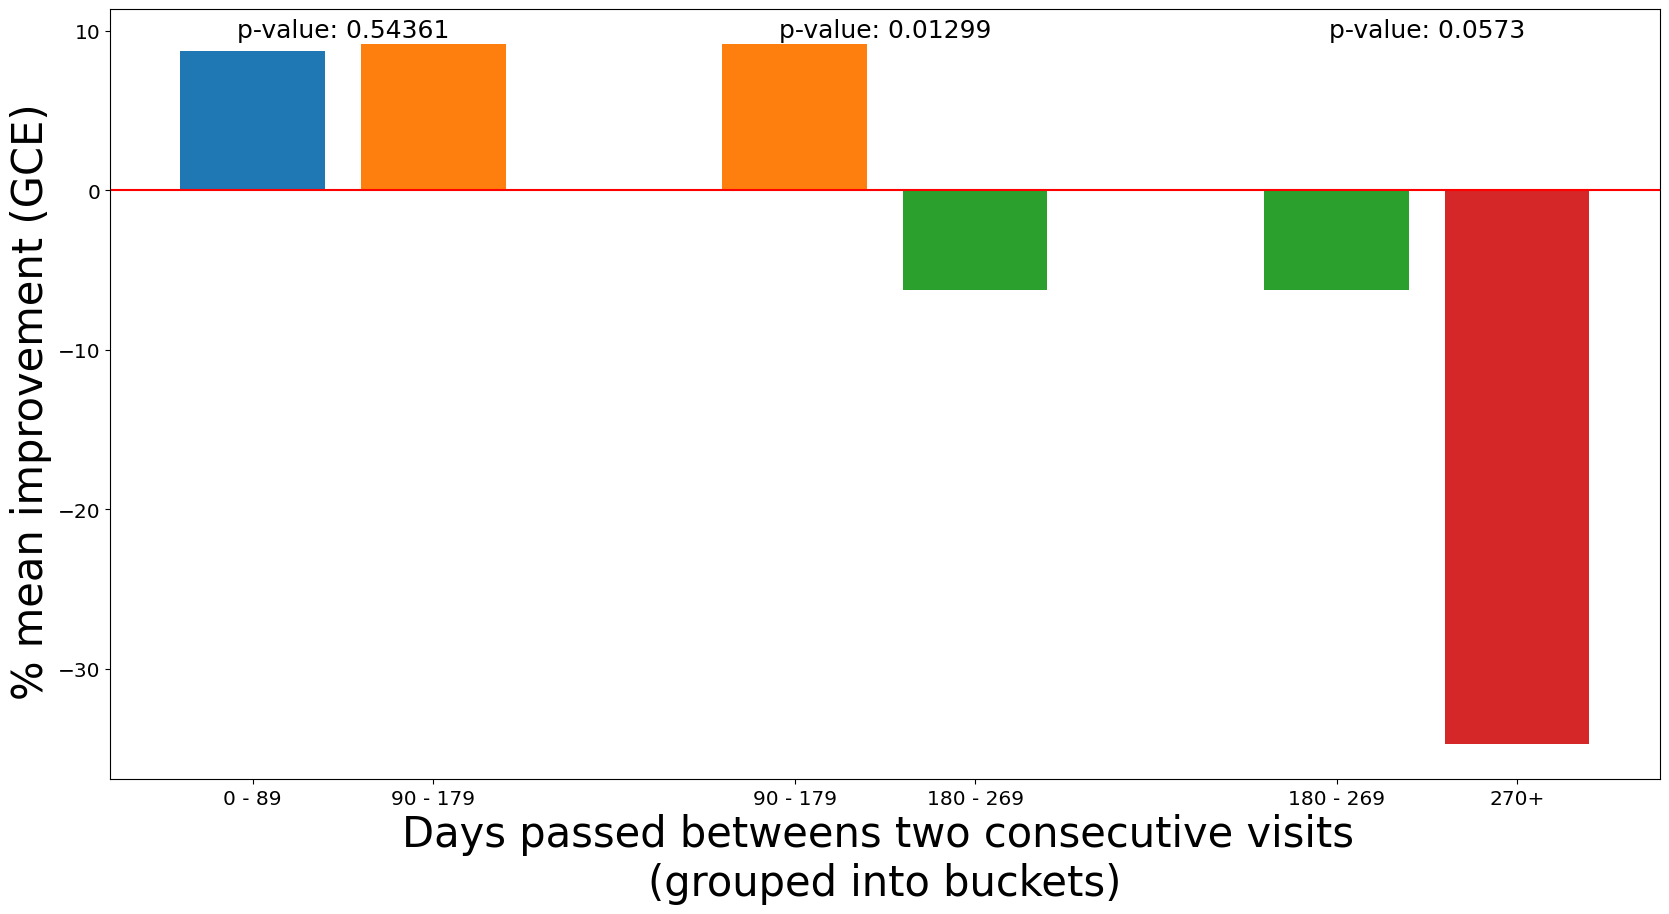

In [7]:
plt.figure(figsize=(20,10))
plt.ylabel("% mean improvement (GCE) ", size = 30)
plt.xlabel("Days passed betweens two consecutive visits \n(grouped into buckets)", size = 30)
plt.axhline(y=0, color='r', linestyle='-')
bucketed_anova(
    bucket_column = "time",
    metric = "inbetween_GCE",
    buckets = [0,90,180,270,10000],
    ttest_type = "greater",
    p_value_text_height = 9.3,
    last_bucket_label = "270+"
)

## Figure 6 graphs:

Text(0, 0.5, '% mean improvement (GCE)')

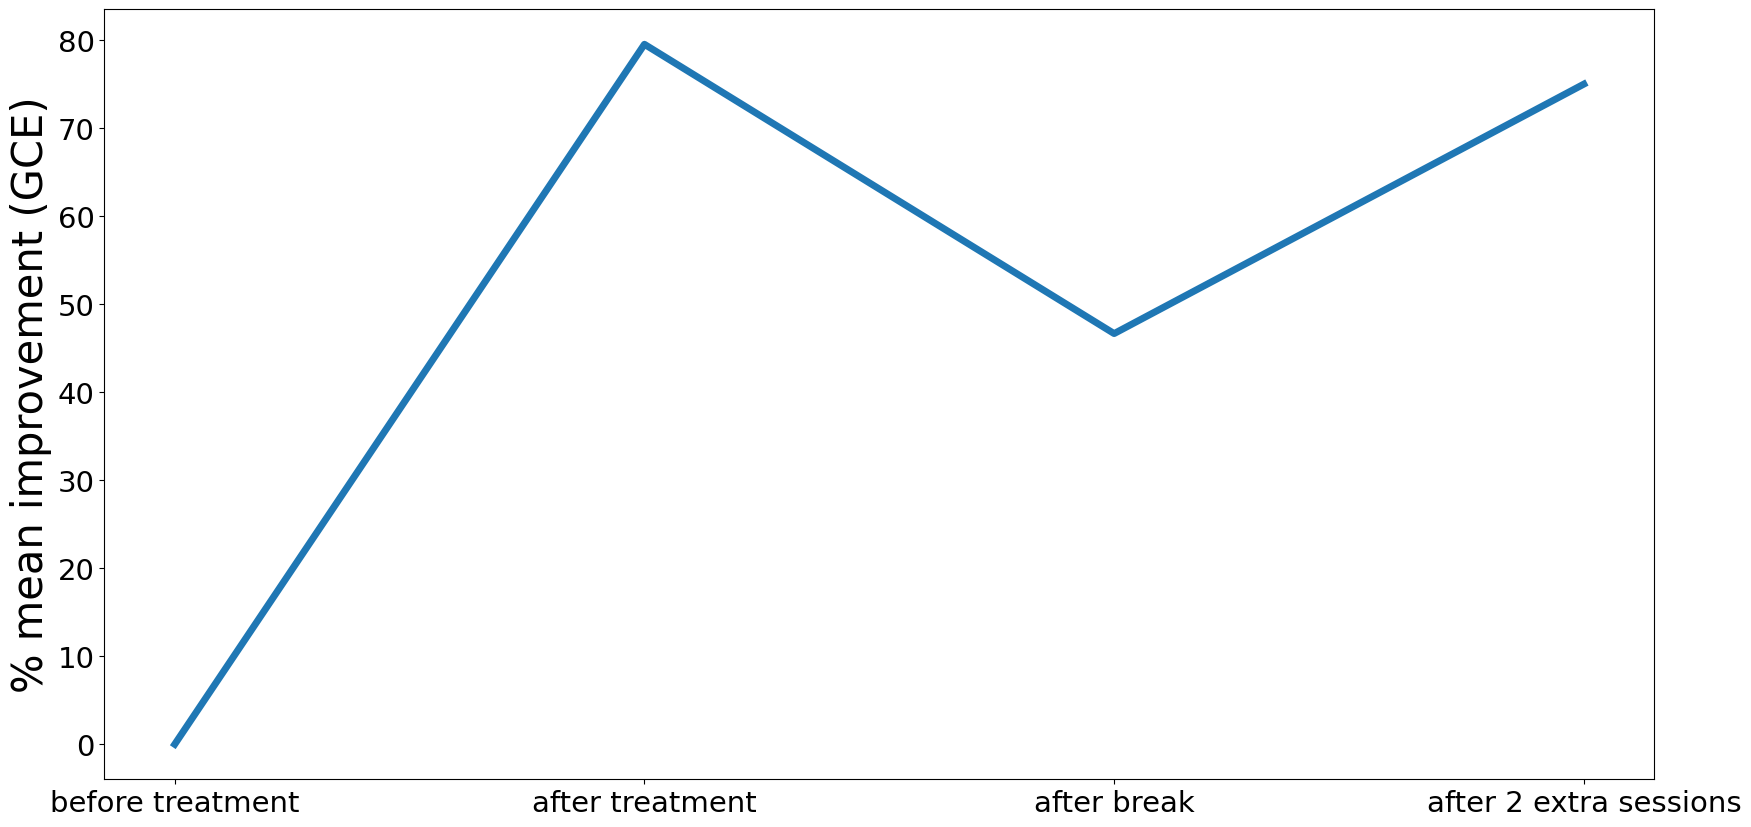

In [8]:
plt.figure(figsize=(20,10))
plot_fig6A_graph()
plt.ylabel("% mean improvement (GCE)", size = 30)